In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
from scipy.io import loadmat
import os
for i in os.listdir():
    if 'mat' in i:
        print(i)

ex4data1.mat
ex4weights.mat


In [3]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')

In [4]:
images = data['X']
label = data['y']

In [5]:
# label[label==10]=0

In [6]:
M,N = images.shape
L= 71  # no. of units in the hidden layer, inlcuding bias
k = len(np.unique(label))   # no. of distinct classes (10)

In [7]:
X = np.append(np.ones((M,1)), images, axis=1)

In [8]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

# one hot encoding to labels

In [9]:
Y = np.array(pd.get_dummies(label.flatten()), dtype=np.float64)

# Random Values of theta

In [10]:
def Random_intitialization(N, L):
    epi = (6**1/2) / (N + L)**1/2
    w = np.random.rand(L,N+1) *(2*epi) -epi
    return w
# N = number of units in first layer
# L = number of units in hidden layer
# k = number of units in output layer

In [11]:
theta_1 = Random_intitialization(N,L-1)
theta_2 = Random_intitialization(L-1,k)
initial_nn_params = np.concatenate((theta_1.flatten(), theta_2.flatten()))

In [12]:
theta_2.shape

(10, 71)

In [13]:
theta_1.shape

(70, 401)

# Cost Function and Gradient Descent Algorithm

In [14]:
def sigmoidGradient(z):
    x = sigmoid(z)
    return x * (1-x)

In [15]:
def nnCostFunction_grad(nn_params,X, y, lam_):

    theta1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta2 = nn_params[(L - 1) * (N + 1):].reshape(k, L)
    
    a1 = X     
    z2 = np.dot(X,theta1.T)

    a2 = np.append(np.ones((M,1)), sigmoid(z2),axis=1) 
    z3 = np.dot(a2,theta2.T) 
    a3 = sigmoid(z3)

    ########### cost ####################
    J=0
    for i in range(k):
        J = J + sum(-y[:,i] * np.log(a3[:,i]) - (1-y[:,i])*np.log(1-a3[:,i]))
    cost = J/M
    
    reg_ = 0
    # no. of layers are 3 hence 2 theta matrices
    for i in [theta1,theta2]:
        reg_ = reg_ + np.sum(np.square(i[:,1:]))
        # taking square of theta from 0th term won't make any difference, it is just better to not include the bias term.
    reg_J = cost + lam_/(2*M) * reg_
    
    ######## Gradients ##############
    
    d3 = a3 - y                                             # dL = h(x) - y
    d2 = (np.dot(d3,theta2[:,1:]) * sigmoidGradient(z2))    # dL-1  = np.dot(dL, theta(i)[:,1:]) * sigmoid(z(i))
                                                            # dL-2  = np.dot(dL-1, theta(i)[:,1:]) * sigmoid(z(i))
                                                            # we will not calculate d1, 
                                                            # since error for the first layer doesnot exist as it contains the input values
    
    delta1 = np.dot(d2.T,a1)   # deltai = np.dot(di+1.T, ai)  a1=X   
    delta2 = np.dot(d3.T,a2)    
    
    theta1 = np.append(np.ones((len(theta1), 1)), theta1[:,1:],axis=1)
    theta2 = np.append(np.ones((len(theta2), 1)), theta2[:,1:],axis=1)
    
    theta1_grad = (delta1/M) + ((lam_/M) * theta1)
    theta2_grad = (delta2/M) + ((lam_/M)* theta2)
    # theta1_grad and theta1 will be of the same dimensions, so will theta2_grad and theta2
    
    grad = np.concatenate((theta1_grad.flatten(),theta2_grad.flatten()))
    return(reg_J, grad)

In [16]:
from scipy.optimize import minimize
res = minimize(nnCostFunction_grad,initial_nn_params, 
               method='L-BFGS-B', args=(X,Y,1), jac=True, options={'maxiter': 100})

# Evaluating

In [17]:
all_theta = res['x']

In [18]:
def pred(nn_params,X,y):
        
    theta1 = nn_params[:(L - 1) * (N + 1)].reshape(L - 1, N + 1)
    theta2 = nn_params[(L - 1) * (N + 1):].reshape(k, L)
    a2  = sigmoid(np.dot(X,theta1.T))
    a2 = np.append(np.ones((M,1)), a2, axis=1)  
    a3  = sigmoid(np.dot(a2,theta2.T))
    
    return (a3.argmax(axis=1)+1).reshape(-1,1)

In [19]:
def accuracy(nn_params,X,y):
    
    a3 = pred(nn_params,X,y)
    
    return np.mean(a3 == label)

In [20]:
predicted = pred(all_theta,X,Y)

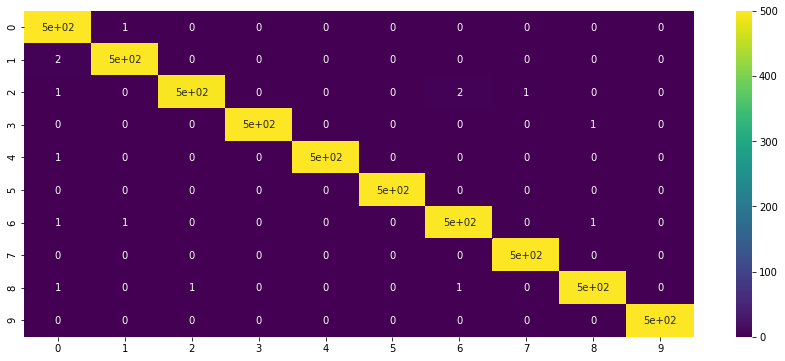

In [21]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(15,6))
sns.heatmap(confusion_matrix(label,predicted), cmap='viridis',annot=True)

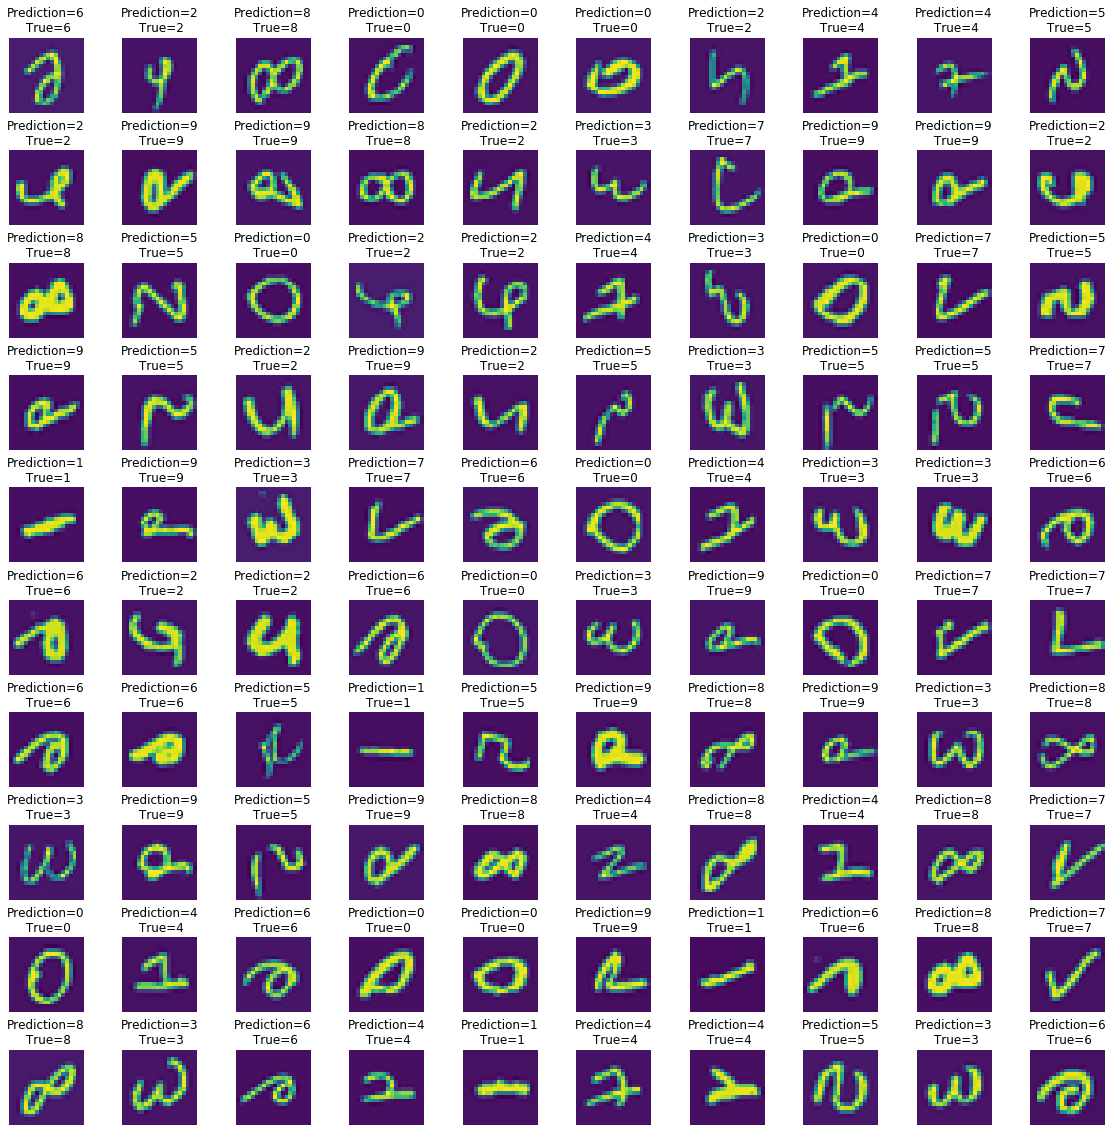

In [22]:
label[label==10] = 0
predicted[predicted==10]=0
rows = 10
cols=10
fig, axes = plt.subplots(rows,cols, figsize=(20,20))
axes = axes.flatten()
training_data = len(images)
for i in np.arange(0,rows*cols):
    index = np.random.randint(0, training_data)
    axes[i].imshow(images[index].reshape(20,20))
    axes[i].axis('off')
    axes[i].set_title("Prediction={}\n True={}".format(predicted[index][0], label[index][0]))
plt.subplots_adjust(hspace=0.5)

In [23]:
np.sum(~(predicted == label))

15